# Neural Style Transfer

El siguiente código fue adaptado de la documentación del siguiente notebook de [hnarayanan](https://github.com/hnarayanan/artistic-style-transfer/blob/master/notebooks/6_Artistic_style_transfer_with_a_repurposed_VGG_Net_16.ipynb). El paper original es [A Neural Algorithm of Artistic Style](http://arxiv.org/abs/1508.06576).

En la carpeta `imagenes_nst` pueden encontrar imágenes para usar como imagen de estilo. Recomendamos, igualmente, seleccionar de la web alguna que les guste. Hacer lo mismo para la imagen de contenido.

In [1]:
from __future__ import print_function
import time
from PIL import Image
#No olvidar la instalación de pillow
#conda install -c anaconda pillow
import numpy as np
from tensorflow.keras import backend
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

C:\Users\walgom\Anaconda37\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\walgom\Anaconda37\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\walgom\Anaconda37\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\walgom\Anaconda37\envs\keras\lib\site-packages\tensorflow\

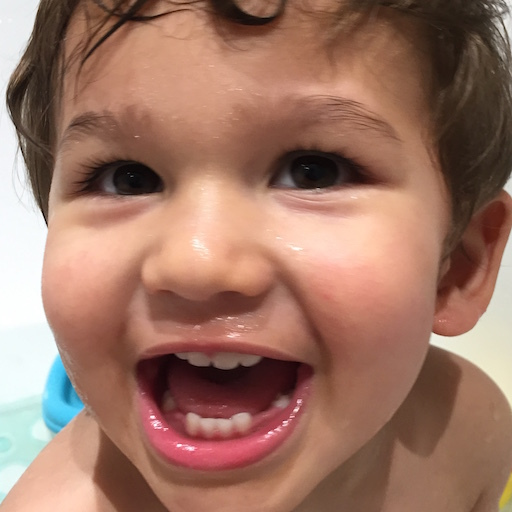

In [2]:
height = 512
width = 512
content_image_path = 'hugo.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

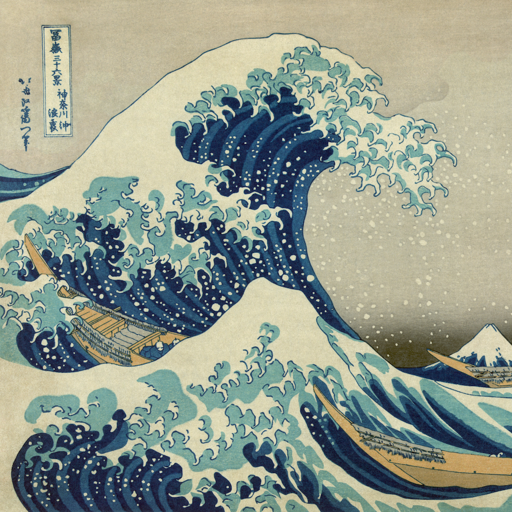

In [3]:
style_image_path = 'wave.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

In [4]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)
style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [5]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [6]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [8]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

In [9]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_1': <tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <t

In [10]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [11]:
loss = backend.variable(value=0.)

In [12]:
print(type(loss))
print(loss.read_value())
print(loss)

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
Tensor("Identity:0", shape=(), dtype=float32)
<tf.Variable 'Variable_2:0' shape=() dtype=float32>


In [13]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

In [14]:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

In [15]:
loss = (content_weight * content_loss(content_image_features,
                                      combination_features))

In [16]:
print(type(loss))

<class 'tensorflow.python.framework.ops.Tensor'>


In [17]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [18]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += ((style_weight / len(feature_layers)) * sl)
    print(type(loss))

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


In [19]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += (total_variation_weight * total_variation_loss(combination_image))

In [20]:
grads = backend.gradients(loss, combination_image)

In [21]:
outputs = [loss]
outputs += grads

In [22]:
f_outputs = backend.function([combination_image], outputs)

In [23]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [ ]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 69935550000.0
Iteration 0 completed in 775s
Start of iteration 1
Current loss value: 45684530000.0
Iteration 1 completed in 737s
Start of iteration 2
Current loss value: 36558010000.0
Iteration 2 completed in 723s
Start of iteration 3
Current loss value: 33864075000.0
Iteration 3 completed in 772s
Start of iteration 4


In [ ]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)